In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from numpy import unique, where
from collections import Counter
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import torch

import sys
sys.path.append("..")
from util.vis import t_sne, pca
from util.style_model import StyleModel
from util.clustering_eval import clustering_summary, print_clustering_classes, clustering_spacy_evaluation

In [2]:
test_data = pd.read_pickle('../data/04-2c_Projects_Test_Set.pkl')

# Style Embeddings from Style Model

In [3]:
model = StyleModel()
model.load_state_dict(torch.load('../model/Project_StyleModel.pt'))

<All keys matched successfully>

In [4]:
messages = test_data["message"].tolist()

vectors = []

for message in tqdm(messages):
    vectors.append(model(message).squeeze().detach().numpy())

vectors = np.array(vectors)

100%|██████████| 54118/54118 [22:19<00:00, 40.40it/s] 


## Centroids

In [5]:
authors_centroids = {}

for group in test_data.groupby('project'):
    author_embeddings = np.array(vectors[group[1].index])
    authors_centroids[group[0]] = np.mean(author_embeddings, axis = 0)

In [6]:
centroids_array = [value for value in authors_centroids.values()]

distances = pd.DataFrame(euclidean_distances(centroids_array, centroids_array))

for i in range(len(distances)):
    for j in range(i + 1):
        distances[j][i] = 0

distances.style.background_gradient(cmap='coolwarm').set_precision(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.000,0.310,0.315,0.268,0.295,0.296,0.371,0.308,0.299,0.304,0.332,0.314,0.324,0.268,0.311
1,0.000,0.000,0.195,0.180,0.194,0.210,0.326,0.184,0.171,0.167,0.229,0.170,0.189,0.180,0.189
2,0.000,0.000,0.000,0.184,0.200,0.180,0.342,0.192,0.097,0.128,0.238,0.111,0.167,0.190,0.129
3,0.000,0.000,0.000,0.000,0.151,0.193,0.292,0.140,0.154,0.139,0.195,0.149,0.159,0.125,0.180
4,0.000,0.000,0.000,0.000,0.000,0.215,0.298,0.123,0.172,0.147,0.209,0.156,0.162,0.138,0.188
5,0.000,0.000,0.000,0.000,0.000,0.000,0.355,0.205,0.148,0.194,0.254,0.179,0.212,0.197,0.164
6,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.297,0.326,0.314,0.344,0.319,0.322,0.303,0.336
7,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.167,0.122,0.184,0.138,0.137,0.131,0.187
8,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.121,0.207,0.098,0.153,0.162,0.114
9,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.191,0.087,0.121,0.145,0.147


## PCA & t-SNE Visualizations

First, the generated vectors are reduced to two and three dimensions with PCA and t-SNE and visualized. Each of the seven authors gets a different color.

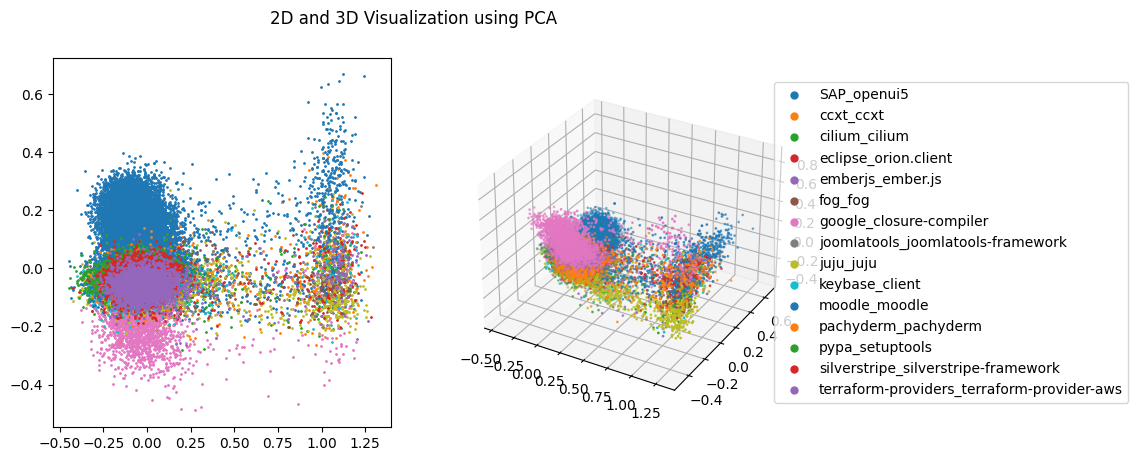

In [7]:
pca_2_prediction, pca_3_prediction = pca(vectors, test_data, projects=True)

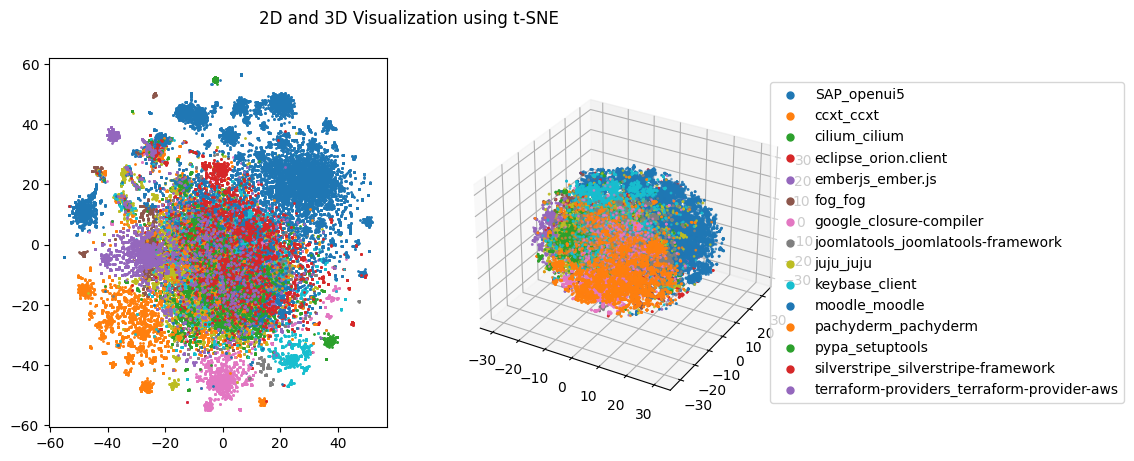

In [8]:
t_sne_2_prediction, t_sne_3_prediction = t_sne(vectors, test_data, projects=True)

## DBSCAN

DBSCAN: Density-based, no number of clusters needed, ability to provide min_samples to make one cluster

Number of Clusters: 4
10 Most common:
[(0, 51942), (-1, 2136), (1, 20), (2, 20)]


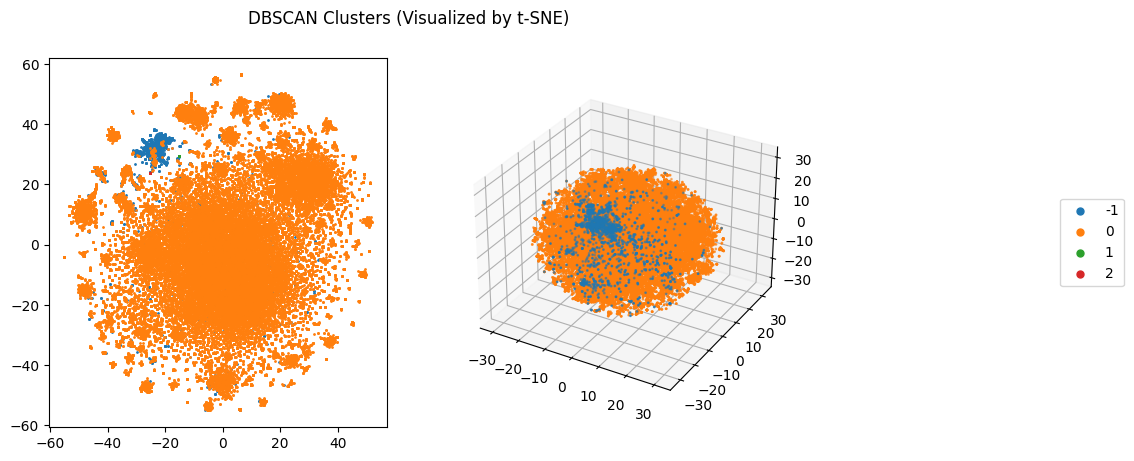

In [9]:
dbscan_model = DBSCAN(eps=0.7, min_samples=10)
dbscan_prediction = dbscan_model.fit_predict(vectors)

dbscan_clusters = unique(dbscan_prediction)

print(f"Number of Clusters: {len(dbscan_clusters)}")
print("10 Most common:")
print(Counter(dbscan_prediction).most_common(10))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax2 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2, projection='3d')

for dbscan_cluster in dbscan_clusters:
    index = where(dbscan_prediction == dbscan_cluster)[0]
    ax2.scatter(t_sne_2_prediction[index, 0], t_sne_2_prediction[index, 1], s=1, label=dbscan_cluster)
    ax3.scatter(t_sne_3_prediction[index, 0], t_sne_3_prediction[index, 1], t_sne_3_prediction[index, 2], s=1, label=dbscan_cluster)

fig.suptitle("DBSCAN Clusters (Visualized by t-SNE)")
plt.legend(loc=5, bbox_to_anchor=(2, 0.5), markerscale = 5)
plt.show()

In [10]:
dbscan_summary = clustering_summary(dbscan_prediction, test_data)
dbscan_summary

There are 4321 different authors.
There are 15 different projects.


,Number of Messages,Number of different Authors,Median number of commits per different Author,Most common Author,Number of different Projects,Median number of commits per different Project,Most common project
0,2136.0,651.0,1.0,"('igor.kroitor@gmail.com', 156)",15.0,93.0,"('moodle_moodle', 595)"
1,51942.0,4225.0,1.0,"('igor.kroitor@gmail.com', 2726)",15.0,2170.0,"('moodle_moodle', 16158)"
2,20.0,1.0,20.0,"('igor.kroitor@gmail.com', 20)",1.0,20.0,"('ccxt_ccxt', 20)"
3,20.0,7.0,1.0,"('igor.kroitor@gmail.com', 13)",2.0,10.0,"('ccxt_ccxt', 19)"


In [11]:
dbscan_summary.describe()

,Number of Messages,Number of different Authors,Median number of commits per different Author,Number of different Projects,Median number of commits per different Project
count,4.000000,4.000000,4.00,4.000000,4.000000
mean,13529.500000,1221.000000,5.75,8.250000,573.250000
std,25627.753049,2025.760104,9.50,7.804913,1065.142674
min,20.000000,1.000000,1.00,1.000000,10.000000
25%,20.000000,5.500000,1.00,1.750000,17.500000
50%,1078.000000,329.000000,1.00,8.500000,56.500000
75%,14587.500000,1544.500000,5.75,15.000000,612.250000
max,51942.000000,4225.000000,20.00,15.000000,2170.000000


In [12]:
clustering_spacy_evaluation(dbscan_prediction, test_data)

,0,1,2,3
length_mean,91.753745,89.636267,32.000000,46.800000
length_std,74.573257,72.079660,7.355270,13.249906
n_uppercase_mean,6.629213,5.834508,0.400000,1.900000
n_uppercase_std,7.630339,6.610886,0.916515,2.406242
polarity_mean,0.020135,0.010809,0.020000,0.033333
polarity_std,0.177076,0.165539,0.114455,0.184917
subjectivity_mean,0.194172,0.186234,0.075000,0.150000
subjectivity_std,0.275145,0.269442,0.129904,0.241997


In [13]:
print_clustering_classes(dbscan_prediction, test_data)


________________ Class 0 ________________

___
1) 
[INTERNAL] sap.m.DateTimeInput: Islamic calendar is not supported.

Change-Id: Ifa<I>c<I>b3ee<I>b<I>e<I>c7a<I>c<I>b4
___
2) 
[FIX] sap.m.Dialog: delayed set of height and width now works

Change-Id: I<I>bb<I>e0bb0d0aeec<I>d4c0f<I>d4a5
BCP: <I>
___
3) 
[INTERNAL] ResourceBundle: allow log-free probing for texts

When the caller of getText() is obviously prepared to get no text, then
do not complain via assert when the text is indeed missing. This avoids
polluting the log in scenarios, where a kind of text-probing is done.

Change-Id: I<I>fe<I>a<I>fe<I>f4a3df<I>f<I>ea<I>f2cf<I>
___
4) 
[FIX] v2.ODataListBinding: isReloadNeeded not parameterized correctly

When using isRelaodNeeded to check whether entities contained in the
list are complete, the select and expand parameters were not passed, so
if the list was using select/expand it was automatically switched to
server mode after every request.

Change-Id: I9bc<I>aaffbdf5b<I>ff<I>dcdd7f5

## K-Means

Centroid-Based, fixed number of Clusters

Goal: Find seven clusters for seven authors

In [14]:
silhouette_scores = []
k_range = range(5, 25, 1)

for k in k_range:
    kmeans = KMeans(k)
    kmeans_prediction = kmeans.fit_predict(vectors)
    silhouette_scores.append(silhouette_score(vectors, kmeans_prediction))

k = k_range[silhouette_scores.index(max(silhouette_scores))]
print(f"Number of clusters with max silhouette score: {k}")

Number of clusters with max silhouette score: 14


Number of Clusters: 14
10 Most common:
[(6, 14188), (8, 11093), (0, 9516), (7, 4656), (12, 4229), (2, 2566), (13, 1691), (3, 1473), (11, 1301), (9, 1175)]


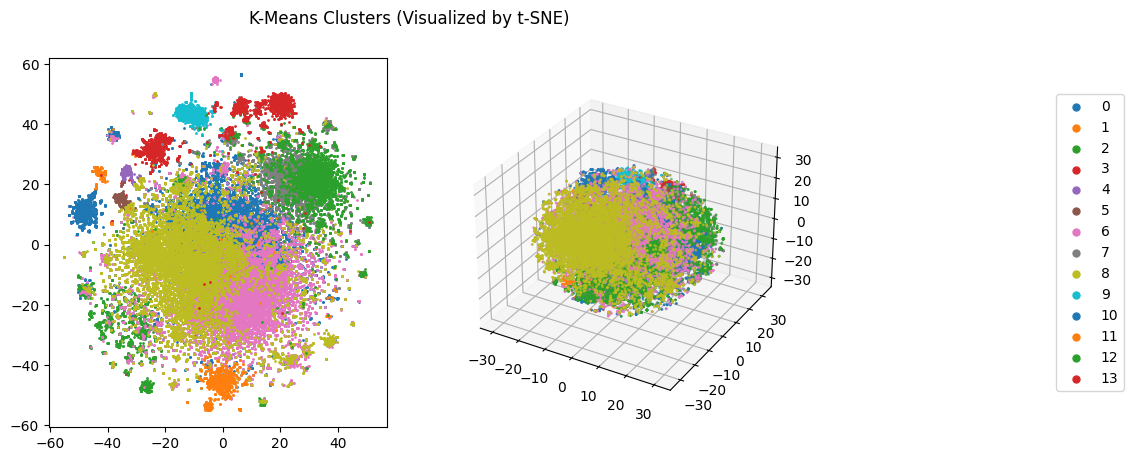

In [15]:
kmeans = KMeans(k)
kmeans_prediction = kmeans.fit_predict(vectors)

kmeans_clusters = unique(kmeans_prediction)

print(f"Number of Clusters: {len(kmeans_clusters)}")
print("10 Most common:")
print(Counter(kmeans_prediction).most_common(10))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax2 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2, projection='3d')

for cluster in kmeans_clusters:
    index = where(kmeans_prediction == cluster)[0]
    ax2.scatter(t_sne_2_prediction[index, 0], t_sne_2_prediction[index, 1], s=1, label=cluster)
    ax3.scatter(t_sne_3_prediction[index, 0], t_sne_3_prediction[index, 1], t_sne_3_prediction[index, 2], s=1, label=cluster)

fig.suptitle("K-Means Clusters (Visualized by t-SNE)")
plt.legend(loc=5, bbox_to_anchor=(2, 0.5), markerscale = 5)
plt.show()

In [16]:
kmeans_summary = clustering_summary(kmeans_prediction, test_data)
kmeans_summary

There are 4321 different authors.
There are 15 different projects.


,Number of Messages,Number of different Authors,Median number of commits per different Author,Most common Author,Number of different Projects,Median number of commits per different Project,Most common project
0,9516.0,1591.0,1.0,"('moodler', 592)",15.0,500.0,"('moodle_moodle', 1996)"
1,348.0,159.0,1.0,"('nick-github@snowmonkey.co.uk', 28)",11.0,8.0,"('fog_fog', 187)"
2,2566.0,306.0,1.0,"('igor.kroitor@gmail.com', 1388)",14.0,10.5,"('ccxt_ccxt', 2409)"
3,1473.0,531.0,1.0,"('igor.kroitor@gmail.com', 123)",15.0,77.0,"('moodle_moodle', 424)"
4,340.0,109.0,1.0,"('roger.peppe@canonical.com', 73)",11.0,5.0,"('juju_juju', 251)"
5,407.0,158.0,1.0,"('tycho.andersen@canonical.com', 22)",14.0,13.0,"('juju_juju', 205)"
6,14188.0,1799.0,1.0,"('igor.kroitor@gmail.com', 689)",15.0,777.0,"('juju_juju', 1994)"
7,4656.0,446.0,2.0,"('skodak', 199)",8.0,5.0,"('moodle_moodle', 4616)"
8,11093.0,1710.0,1.0,"('igor.kroitor@gmail.com', 314)",15.0,672.0,"('juju_juju', 2186)"
9,1175.0,98.0,2.0,"('skodak', 401)",1.0,1175.0,"('moodle_moodle', 1175)"


In [17]:
kmeans_summary.describe()

,Number of Messages,Number of different Authors,Median number of commits per different Author,Number of different Projects,Median number of commits per different Project
count,14.000000,14.000000,14.00000,14.000000,14.000000
mean,3865.571429,563.785714,1.50000,9.857143,272.392857
std,4486.315958,628.914471,0.85485,5.201437,389.827436
min,340.000000,98.000000,1.00000,1.000000,1.000000
25%,1145.000000,163.000000,1.00000,6.500000,5.000000
50%,1582.000000,275.500000,1.00000,11.000000,11.750000
75%,4549.250000,509.750000,2.00000,14.750000,550.625000
max,14188.000000,1799.000000,4.00000,15.000000,1175.000000


In [18]:
clustering_spacy_evaluation(kmeans_prediction, test_data)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
length_mean,87.961328,113.801724,52.081839,99.631365,83.073529,91.597052,87.262898,96.274055,87.683945,87.540426,193.706608,100.262106,82.833767,99.588409
length_std,69.823187,88.552623,41.828803,75.915364,82.500395,85.906954,71.351526,70.642380,76.992639,49.342139,73.547751,44.254102,62.978942,67.685403
n_uppercase_mean,5.370534,8.034483,2.897116,7.084861,3.223529,3.882064,4.906893,6.970146,3.996845,13.731064,23.424670,12.710992,6.517616,5.667652
n_uppercase_std,6.698951,10.475147,4.076282,7.723954,4.426860,5.041922,6.004098,4.528614,5.461146,6.375553,6.769412,7.095772,3.946136,4.828411
polarity_mean,0.019370,0.002570,-0.007737,0.008302,0.000843,0.005442,0.007673,0.015131,0.016541,0.016625,0.004983,-0.005001,0.001862,0.021320
polarity_std,0.160201,0.137889,0.127771,0.160271,0.154630,0.189884,0.175124,0.164778,0.164386,0.175374,0.115752,0.156670,0.185716,0.162224
subjectivity_mean,0.195528,0.164250,0.101213,0.182424,0.141265,0.195168,0.192210,0.197001,0.183906,0.188431,0.168162,0.146867,0.209002,0.205394
subjectivity_std,0.279042,0.248000,0.217347,0.259496,0.237900,0.276456,0.273911,0.266024,0.275751,0.253849,0.229061,0.265854,0.263355,0.262872


In [19]:
print_clustering_classes(kmeans_prediction, test_data)


________________ Class 0 ________________

___
1) 
[INTERNAL] Windows Phone <I>: Table export

Updated JSDoc, as Windows Phone <I> doesn't support the file export.
BCP: <I>

Change-Id: Ia4fb<I>d<I>e<I>a5a5c<I>c<I>dce<I>b<I>
___
2) 
[INTERNAL] NavContainer: cleanupControlWithoutRendering was missing

 - Controls are responsible for the rendering of all their children
controls. But in some cases like performance it makes sense that a
control only renders a subset of its children. In this change we clean
up the rendering state of the page controls that are not rendered with
NavContainer.

BCP: <I>

Change-Id: I0d<I>e0e5cae<I>b<I>c<I>e5d<I>fd<I>ce1d6
___
3) 
[INTERNAL] Tree: acc enhancement

Change-Id: I<I>ac<I>f<I>f8a8c<I>a6f<I>dbe5f9f<I>def
BCP: <I>
___
4) 
[FIX] Blackberry: focused input does not scroll into view

- a focused input field is covered by the soft keyboard
  and is not visible on Blackberry devices

Change-Id: I8b<I>cd5b<I>b<I>b<I>f<I>ef<I>fb<I>
___
5) 
[FIX] Controller: c